# Citizen weather stations data

In this notebook, we will assemble a time series of meteorological measurements from the citizen weather stations (CWS) in the study region for the heatwave period determined using the official weather stations data.

In [ ]:
%load_ext autoreload
%autoreload 2

In [ ]:
from meteora import settings

settings.LOG_CONSOLE = True

In [ ]:
import datetime

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import ultraplot as uplt
from meteora.clients import NetatmoClient

NETATMO_SCALE = "1hour"  # could also be "30min"

In [ ]:
# spatial extent
agglom_extent_filepath = "../data/raw/agglom-extent.gpkg"

# official station data just to get the time range
official_ts_df_filepath = "../data/interim/official-ts-df.csv"

# we need to dump both the time series of measurements and the stations' locations
dst_ts_df_filepath = "../data/raw/cws-ts-df.csv"
dst_stations_gdf_filepath = "../data/raw/cws-stations.gpkg"

# plotting
xmargin = 0  # uplt.rc["axes.xmargin"]
refwidth = 3  # uplt.rc["subplots.refwidth"]
uplt.rc.update(**{"axes.xmargin": xmargin, "subplots.refwidth": refwidth})

In [ ]:
# heatwave start and end
# add one extra hour before and after because of how the netatmo API works
heatwave_range_df = (
    pd.read_csv(official_ts_df_filepath, parse_dates=["time"])
    .groupby("heatwave", sort=False)["time"]
    .agg(["min", "max"])
)
heatwave_range_df["min"] = heatwave_range_df["min"].apply(
    lambda x: x - datetime.timedelta(hours=1)
)
heatwave_range_df["max"] = heatwave_range_df["max"].apply(
    lambda x: x + datetime.timedelta(hours=1)
)
heatwave_range_df

,min,max
heatwave,,
2022/06/18-2022/06/21,2022-06-17 23:00:00,2022-06-22 01:00:00
2022/07/18-2022/07/20,2022-07-17 23:00:00,2022-07-21 01:00:00
2022/08/01-2022/08/05,2022-07-31 23:00:00,2022-08-06 01:00:00
2023/07/09-2023/07/11,2023-07-08 23:00:00,2023-07-12 01:00:00
2023/08/18-2023/08/25,2023-08-17 23:00:00,2023-08-26 01:00:00


In [ ]:
# select only land extent (agglom_extent_filepath has two geometries: land and lake)
region = gpd.read_file(agglom_extent_filepath)["geometry"].iloc[:1]

# client_id = os.getenv("NETATMO_CLIENT_ID")
# client_secret = os.getenv("NETATMO_CLIENT_SECRET")
client_id = "67fa00767a2302ed950f420f"
client_secret = "Pfn04L1hPwSSrNGMt9taof2R3XeYY8AdcTlMh"
client = NetatmoClient(
    region=region,
    client_id=client_id,
    client_secret=client_secret,
)

100%|███████████████████████████████████████████████████| 3/3 [00:00<00:00, 84.57it/s]


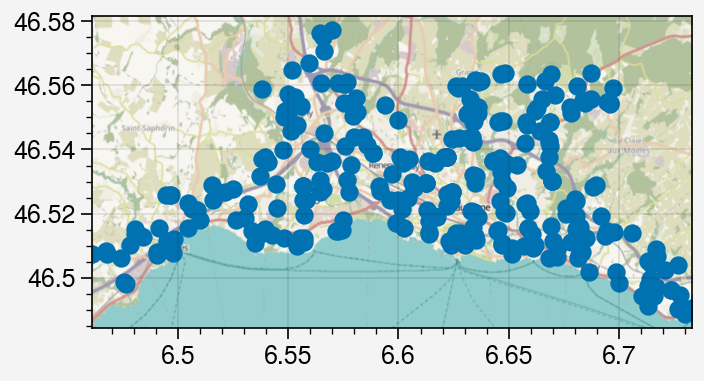

In [ ]:
fig, ax = uplt.subplot(tight=True)
ax = client.stations_gdf.plot(ax=ax)
cx.add_basemap(ax, crs=client.stations_gdf.crs, attribution=False)

*(C) OpenStreetMap contributors, Tiles style by Humanitarian OpenStreetMap Team hosted by OpenStreetMap France*

In [ ]:
cws_ts_dfs = []
for heatwave, start, end in heatwave_range_df.itertuples(index=True):
    _cws_ts_df = client.get_ts_df(
        variables="temperature",
        start=start,
        end=end,
        scale=NETATMO_SCALE,
    )
    # filter by heatwave range because the API sometimes returns more records
    _cws_ts_df = _cws_ts_df[
        pd.Series(_cws_ts_df.index.get_level_values("time")).between(start, end).values
    ]
    cws_ts_dfs.append(_cws_ts_df.assign(**{"heatwave": heatwave}))

cws_ts_df = (
    pd.concat(cws_ts_dfs, axis="rows")
    .reset_index()
    .pivot(index=["heatwave", "time"], columns=["station_id"], values="temperature")
)
cws_ts_df.head()

station_id                                 70:ee:50:00:0a:ce  \
heatwave              time                                     
2022/06/18-2022/06/21 2022-06-17 23:30:00               13.1   
                      2022-06-18 00:30:00               13.3   
                      2022-06-18 01:30:00               13.5   
                      2022-06-18 02:30:00               13.6   
                      2022-06-18 03:30:00               13.9   

station_id                                 70:ee:50:00:0d:6c  \
heatwave              time                                     
2022/06/18-2022/06/21 2022-06-17 23:30:00                NaN   
                      2022-06-18 00:30:00                NaN   
                      2022-06-18 01:30:00                NaN   
                      2022-06-18 02:30:00                NaN   
                      2022-06-18 03:30:00                NaN   

station_id                                 70:ee:50:00:1d:3c  \
heatwave              time                                     
2022/06/18-2022/06/21 2022-06-17 23:30:00               23.6   
                      2022-06-18 00:30:00               23.1   
                      2022-06-18 01:30:00               22.9   
                      2022-06-18 02:30:00               22.2   
                      2022-06-18 03:30:00               21.6   

station_id                                 70:ee:50:00:28:ea  \
heatwave              time                                     
2022/06/18-2022/06/21 2022-06-17 23:30:00               25.0   
                      2022-06-18 00:30:00               24.1   
                      2022-06-18 01:30:00               23.4   
                      2022-06-18 02:30:00               22.9   
                      2022-06-18 03:30:00               23.1   

station_id                                 70:ee:50:00:3b:46  \
heatwave              time                                     
2022/06/18-2022/06/21 2022-06-17 23:30:00               25.1   
                      2022-06-18 00:30:00               24.4   
                      2022-06-18 01:30:00               24.1   
                      2022-06-18 02:30:00               23.7   
                      2022-06-18 03:30:00               23.3   

station_id                                 70:ee:50:00:3b:86  \
heatwave              time                                     
2022/06/18-2022/06/21 2022-06-17 23:30:00               25.4   
                      2022-06-18 00:30:00               25.0   
                      2022-06-18 01:30:00               24.4   
                      2022-06-18 02:30:00               24.3   
                      2022-06-18 03:30:00               24.0   

station_id                                 70:ee:50:00:3e:82  \
heatwave              time                                     
2022/06/18-2022/06/21 2022-06-17 23:30:00               24.4   
                      2022-06-18 00:30:00               23.6   
                      2022-06-18 01:30:00               23.2   
                      2022-06-18 02:30:00               22.7   
                      2022-06-18 03:30:00               22.3   

station_id                                 70:ee:50:00:5e:98  \
heatwave              time                                     
2022/06/18-2022/06/21 2022-06-17 23:30:00               23.7   
                      2022-06-18 00:30:00               23.2   
                      2022-06-18 01:30:00               23.1   
                      2022-06-18 02:30:00               22.6   
                      2022-06-18 03:30:00               21.9   

station_id                                 70:ee:50:00:62:9c  \
heatwave              time                                     
2022/06/18-2022/06/21 2022-06-17 23:30:00               21.1   
                      2022-06-18 00:30:00               20.6   
                      2022-06-18 01:30:00               19.9   
                      2022-06-18 02:30:00               19.1   
                      20

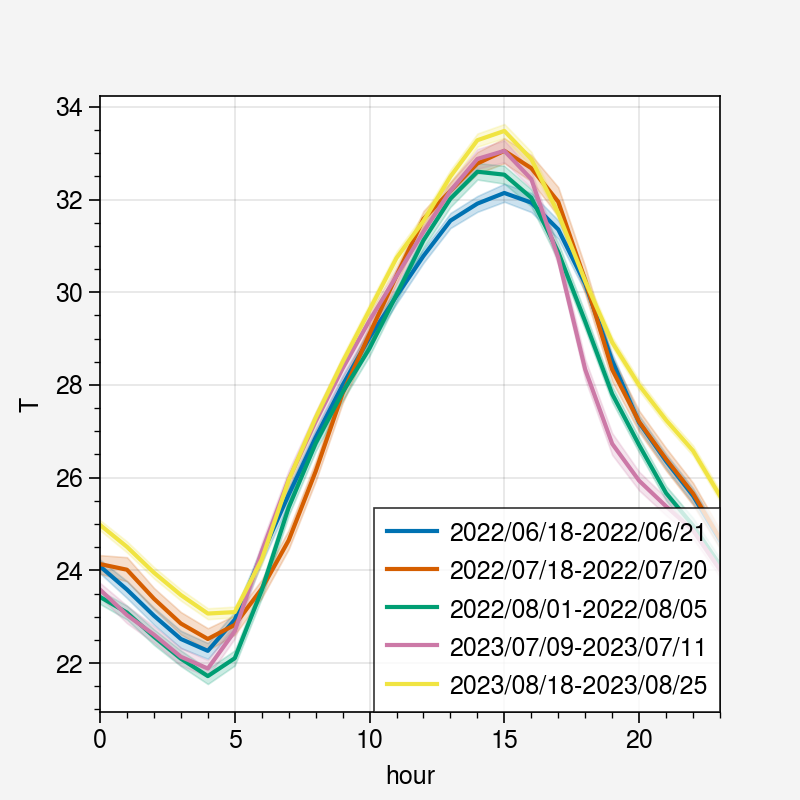

In [ ]:
fig, ax = plt.subplots()

for heatwave, heatwave_ts_df in cws_ts_df.groupby(level="heatwave"):
    # heatwave_ts_df = heatwave_ts_df.stack(dropna=True).reset_index(name="T")
    heatwave_ts_df = heatwave_ts_df.reset_index().melt(
        id_vars=["heatwave", "time"], value_name="T"
    )
    sns.lineplot(
        heatwave_ts_df.assign(**{"hour": heatwave_ts_df["time"].dt.hour}),
        x="hour",
        y="T",
        ax=ax,
        label=heatwave,
    )

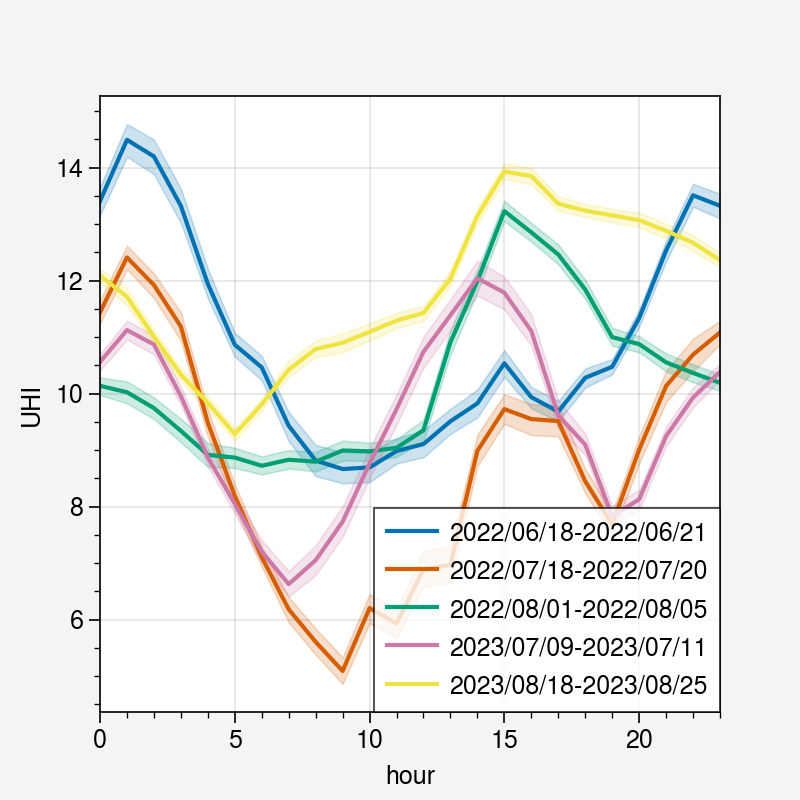

In [ ]:
fig, ax = plt.subplots()

for heatwave, heatwave_ts_df in cws_ts_df.apply(
    lambda row: row - row.min(), axis="columns"
).groupby(level="heatwave"):
    # heatwave_ts_df = heatwave_ts_df.stack(dropna=True).reset_index(name="UHI")
    heatwave_ts_df = heatwave_ts_df.reset_index().melt(
        id_vars=["heatwave", "time"], value_name="UHI"
    )
    sns.lineplot(
        heatwave_ts_df.assign(**{"hour": heatwave_ts_df["time"].dt.hour}),
        x="hour",
        y="UHI",
        ax=ax,
        label=heatwave,
    )

In [ ]:
# dump filtered data
cws_ts_df.to_csv(dst_ts_df_filepath)
client.stations_gdf.to_file(dst_stations_gdf_filepath)